# Imports

In [1]:
from experiments.ina_markov import (dias_iv_tau,
                                    nakajima_inactivation,
                                    zhang_recovery)

INFO:myokit:Loading Myokit version 1.28.3


In [2]:
from ionchannelABC.experiment import setup
from ionchannelABC import plot_sim_results

In [3]:
#modelfile = 'models/ina_simple.mmt'
modelfile = 'models/standardised_ina.mmt'
#modelfile = 'models/Korhonen2009_iNa.mmt'

In [5]:
observations, model, summary_statistics = setup(modelfile,
                                                dias_iv_tau,
                                                nakajima_inactivation,
                                                zhang_recovery)

In [6]:
assert(len(observations)==len(summary_statistics(model({}))))

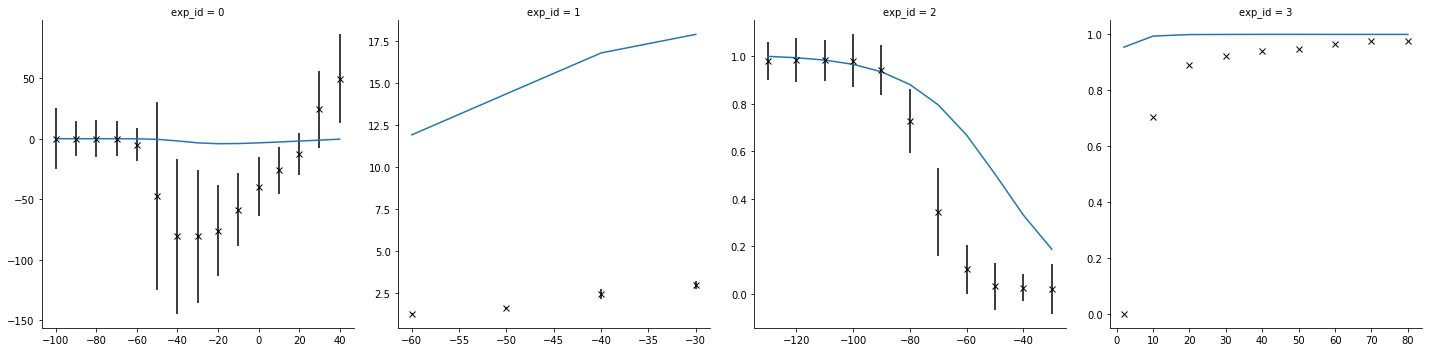

In [7]:
g = plot_sim_results(modelfile, dias_iv_tau, nakajima_inactivation, zhang_recovery)

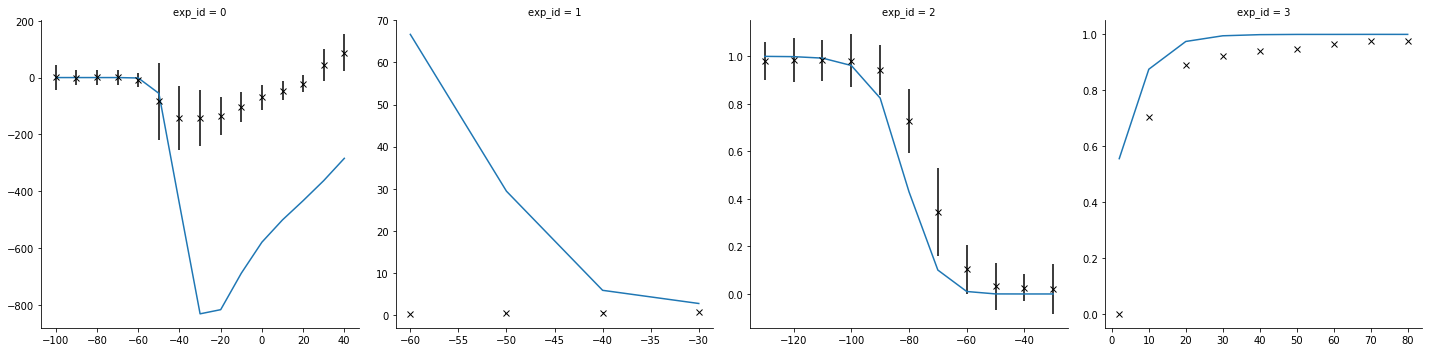

In [7]:
g = plot_sim_results("models/Korhonen2009_iNa.mmt", dias_iv_tau, nakajima_inactivation, zhang_recovery)

## Set limits and generate uniform initial priors

In [8]:
from pyabc import Distribution, RV
limits = {'ina.g_Na': (0., 200.),
          'ina.s': (0., 1.),
          'ina.P_Na': (0., 1.),
          'log_ina.p_1': (-7., 3.),
          'ina.p_2': (1e-7, 0.4),
          'log_ina.p_3': (-7., 3.),
          'ina.p_4': (1e-7, 0.4),
          'log_ina.p_5': (-7., 3.),
          'ina.p_6': (1e-7, 0.4),
          'log_ina.p_7': (-7., 3.),
          'ina.p_8': (1e-7, 0.4),
          'ina.A': (1., 100.)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

## Run ABC calibration

In [9]:
import os, tempfile
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "hl1_ina.db"))
print(db_path)

sqlite:////scratch/cph211/tmp/hl1_ina.db


In [10]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [11]:
from pyabc.populationstrategy import AdaptivePopulationSize, ConstantPopulationSize
from ionchannelABC import theoretical_population_size
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 4096 particles


In [12]:
from pyabc import ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor

abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.2),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=8),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.45701186068134136, '1': 0.7125734324547999, '2': 0.7125734324547999, '3': 0.7125734324547999, '4': 0.7125734324547999, '5': 0.14851884550496297, '6': 0.18002048918115338, '7': 0.20844095178048705, '8': 0.3046500586142607, '9': 0.38326942857922836, '10': 0.47521432454916374, '11': 0.5940365454408268, '12': 0.660036770606894, '13': 0.36001815484545374, '14': 0.3126843799310151, '15': 2.6721503717054995, '16': 2.6721503717054995, '17': 2.6721503717054995, '18': 2.6721503717054995, '19': 0.9716910442565454, '20': 0.9716910442565454, '21': 0.9716910442565454, '22': 0.9716910442565454, '23': 0.9716910442565454, '24': 0.9716910442565454, '25': 0.9716910442565454, '26': 0.9716910442565454, '27': 0.9716910442565454, '28': 0.9716910442565454, '29': 0.9716910442565454, '30': 1.1876223874246665, '31': 1.1876223874246665, '32': 1.1876223874246665, '33': 1.1876223874246665, '34': 1.1876223874246665, '35': 1.1876223874246665, '36': 1.1876223874246665, '37': 1.18

In [13]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [14]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=2, start_time=2019-09-24 13:02:43.635254, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=200, min_acceptance_rate=0.005)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0


In [70]:
from pyabc import ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor

abc_continued = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.25),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(),
             sampler=MulticoreEvalParallelSampler(n_procs=8),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.5586797665968862, '1': 0.6968753210623062, '2': 0.6968753210623062, '3': 0.6968753210623062, '4': 0.6968753210623062, '5': 0.18155868825427915, '6': 0.22006825977873404, '7': 0.25481120362246595, '8': 0.3724232088563206, '9': 0.4685324240450449, '10': 0.5809315922934932, '11': 0.6968753210623062, '12': 0.6968753210623062, '13': 0.44010861866874856, '14': 0.38224486370640876, '15': 2.6132824539836483, '16': 2.6132824539836483, '17': 2.6132824539836483, '18': 2.6132824539836483, '19': 0.9502845287213266, '20': 0.9502845287213266, '21': 0.9502845287213266, '22': 0.9502845287213266, '23': 0.9502845287213266, '24': 0.9502845287213266, '25': 0.9502845287213266, '26': 0.9502845287213266, '27': 0.9502845287213266, '28': 0.9502845287213266, '29': 0.9502845287213266, '30': 1.161458868437177, '31': 1.161458868437177, '32': 1.161458868437177, '33': 1.161458868437177, '34': 1.161458868437177, '35': 1.161458868437177, '36': 1.161458868437177, '37': 1.1614588684

In [71]:
abc_continued.load(db_path, 1)

1

In [ ]:
history = abc_continued.run(minimum_epsilon=0., max_nr_populations=200, min_acceptance_rate=0.001)

In [ ]:
history = abc_continued.run(minimum_epsilon=0., max_nr_populations=200, min_acceptance_rate=0.0001)

## Results analysis

In [4]:
from pyabc import History

In [ ]:
db_path = 'sqlite:////storage/hhecm/cellrotor/chouston/abc-hl1-results/ina/3/hl1_ina.db'

In [5]:
db_path = 'sqlite:////scratch/cph211/tmp/hl1_ina.db'

In [6]:
history = History(db_path)
history.all_runs()

[<ABCSMC(id=1, start_time=2019-09-13 09:55:07.696205, end_time=2019-09-14 08:45:58.719723)>]

In [9]:
history.id = 1
df, w = history.get_distribution(m=0)

In [20]:
df.describe()

name,ina.P_Na,ina.g_Na,ina.p_2,ina.p_4,ina.p_6,ina.p_8,log_ina.p_1,log_ina.p_3,log_ina.p_5,log_ina.p_7
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.451513,101.014628,0.053915,0.040684,0.081849,0.076731,-1.472158,0.908410,0.626420,-4.960552
std,0.241972,46.418774,0.034222,0.040686,0.021925,0.018318,0.745385,1.049835,0.399401,0.922715
min,0.001550,1.615329,0.000128,0.000008,0.013615,0.004875,-3.994653,-4.611050,-0.491625,-6.983676
25%,0.226623,66.662627,0.025904,0.013768,0.067492,0.065350,-1.945468,0.256557,0.390440,-5.614952
50%,0.460531,102.315891,0.050763,0.030195,0.080296,0.077636,-1.431894,0.946236,0.580084,-5.001875
75%,0.644076,135.355054,0.077784,0.054717,0.092701,0.089736,-0.964837,1.654935,0.772021,-4.369767
max,0.995754,199.803515,0.201781,0.360923,0.178558,0.120850,1.461286,2.993987,2.997894,-1.225842


/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/seaborn/axisgrid.py:375: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()


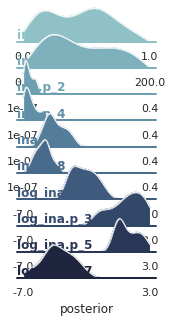

In [63]:
from ionchannelABC import plot_parameters_kde
g = plot_parameters_kde(df, w, limits)#, aspect=12,height=0.6)

In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

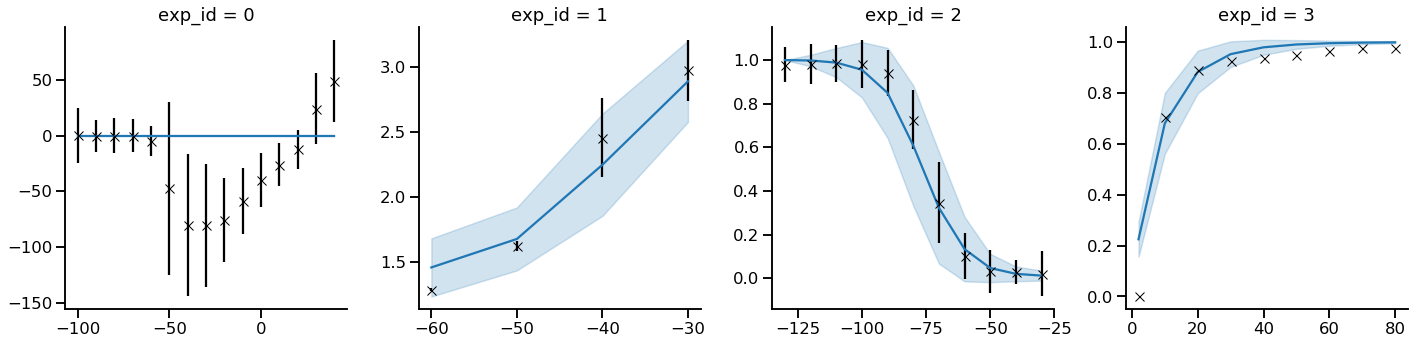

In [11]:
sns.set_context('talk')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(modelfile, dias_iv_tau, nakajima_inactivation, zhang_recovery, df=df, w=w)

#xlabels = ["voltage, mV"]*3
#ylabels = ["current density, pA/pF", "relative inactivation", "relative recovery"]
#titles = ["IV curve", "Inactivation", "Recovery"]
#for ax, xl in zip(g.axes.flatten(), xlabels):
#    ax.set_xlabel(xl)
#for ax, yl in zip(g.axes.flatten(), ylabels):
#    ax.set_ylabel(yl)
#for ax, t in zip(g.axes.flatten(), titles):
#    ax.set_title(t)
    
plt.tight_layout()

In [11]:
#g.savefig('/storage/hhecm/cellrotor/chouston/abc-hl1-results/ina/calibrated.pdf')

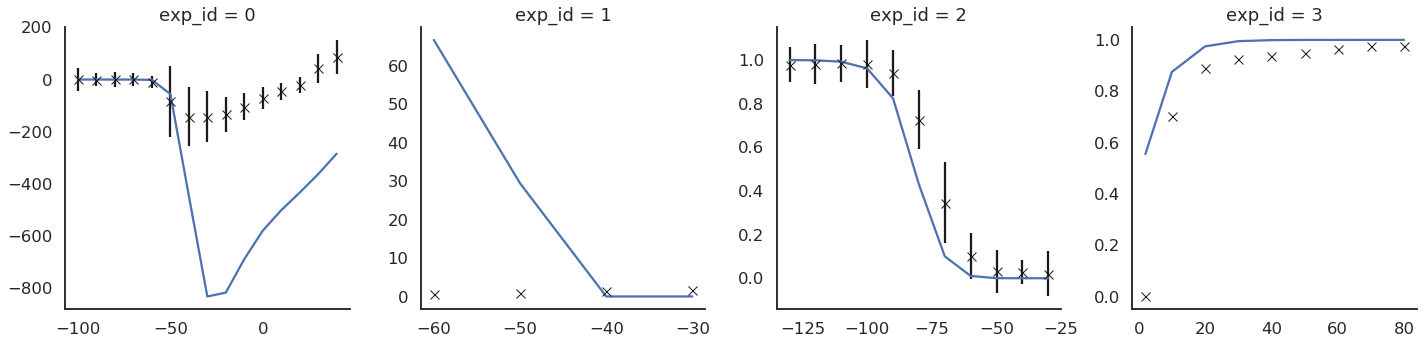

In [47]:
g = plot_sim_results('models/Korhonen2009_iNa.mmt', dias_iv_tau, nakajima_inactivation, zhang_recovery)

In [39]:
from ionchannelABC.visualization import plot_experiment_traces

In [40]:
def split_iv(data):
    out = []
    for d in data.split_periodic(5100, adjust=True):
        d = d.trim(4950, 5100, adjust=True)
        out.append(d)
    return out
def split_inact(data):
    out = []
    for d in data.split_periodic(5600, adjust=True):
        d = d.trim(5450, 5600, adjust=True)
        out.append(d)
    return out

In [41]:
import data.ina.data_ina as data
times_rec, _, _ = data.Recovery_Zhang()
split_times = [3040+tw for tw in times_rec]
for i, time in enumerate(split_times[:-1]):
    split_times[i+1] += split_times[i]
    
def split_rec(data):
    out = []
    for i, time in enumerate(split_times):
        d_, data = data.split(time)
        out.append(
            d_.trim(d_['engine.time'][0]+3000,
                    d_['engine.time'][0]+3040+times_rec[i],
                    adjust=True)
        )
    return out

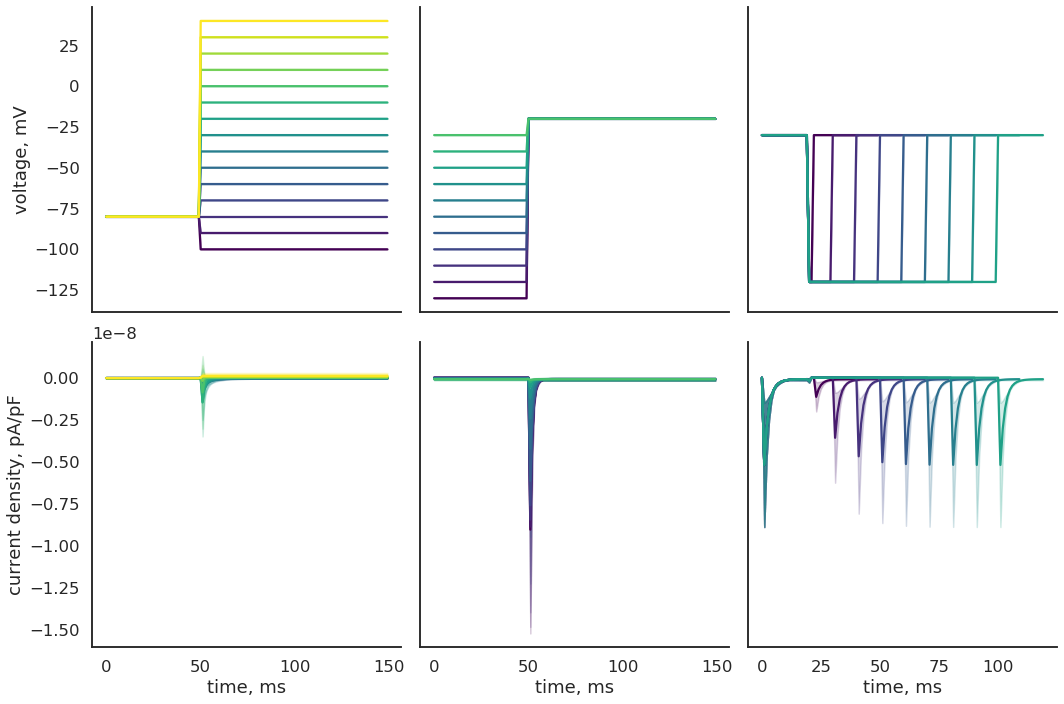

In [43]:
sns.set_context('talk')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_experiment_traces(modelfile, 'ina.i_Na', [split_iv, split_inact, split_rec],
                           dias_iv_tau, nakajima_inactivation, zhang_recovery, df=df, w=w, 
                           log_interval=1, n_samples=2)

xlabel = "time, ms"
ylabels = ["voltage, mV", "current density, pA/pF"]
for ax in g.axes[1,:]:
    ax.set_xlabel(xlabel)
for ax, yl in zip(g.axes, ylabels):
    ax[0].set_ylabel(yl)
for ax in g.axes.flatten():
    ax.set_title('')
    
plt.tight_layout()

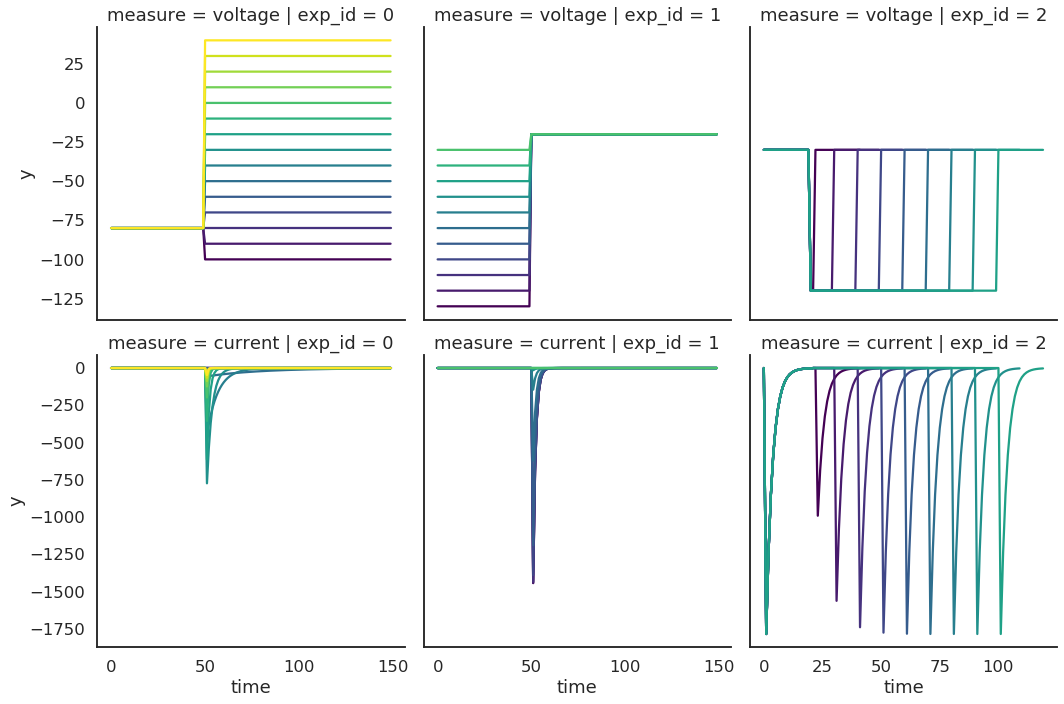

In [45]:
g = plot_experiment_traces('models/Korhonen2009_iNa.mmt', 'ina.i_Na', [split_iv, split_inact, split_rec],
                           dias_iv_tau, nakajima_inactivation, zhang_recovery,
                           log_interval=1)

In [19]:
#g.savefig('/storage/hhecm/cellrotor/chouston/abc-hl1-results/ina/protocol.pdf')

In [20]:
# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')

In [22]:
# Generate sim results samples
import pandas as pd
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    results = summary_statistics(model(th))
    output = pd.DataFrame({'x': observations.x, 'y': list(results.values()),
                           'exp_id': observations.exp_id})
    #output = model.sample(pars=th, n_x=50)
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

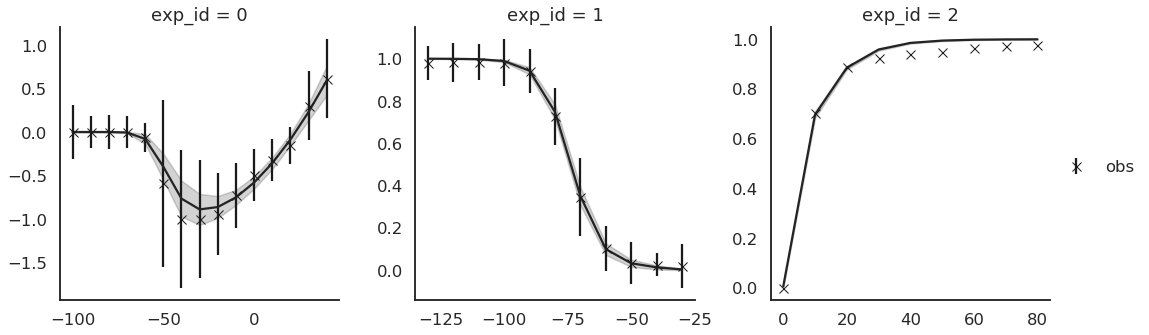

In [23]:
from ionchannelABC import plot_sim_results
import seaborn as sns
sns.set_context('talk')
g = plot_sim_results(samples, obs=observations)

In [113]:
# Require discrete samples for exact measurements at -20mV
discrete_samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    output = model.sample(pars=th)
    output['sample'] = i
    output['distribution'] = 'post'
    discrete_samples = discrete_samples.append(output, ignore_index=True)

In [114]:
# Amplitude at -20 mV
grouped = discrete_samples[discrete_samples['exp']==0].groupby('sample')
def get_amplitude(group):
    return group.loc[group.x==-20]['y']
print(grouped.apply(get_amplitude).mean())
print(grouped.apply(get_amplitude).std())

-163.74165119888335
0.14129370301730562


In [115]:
import scipy.stats as st
peak_current = discrete_samples[discrete_samples['exp']==0].groupby('sample').apply(get_amplitude).tolist()
rv = st.rv_discrete(values=(peak_current, [1/len(peak_current),]*len(peak_current)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -163.81705987307208
95% CI: (-163.85178097293564, -163.4658692841079)


In [116]:
# Voltage and slope factor at half-activation
from scipy.optimize import curve_fit
grouped = samples[samples['exp']==1].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, Shalf):
        return 1/(1+np.exp((Vhalf-V)/Shalf))
    guess = (-50, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y, guess)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [117]:
print(output.mean())
print(output.std())

0   -34.955683
1     7.200565
dtype: float64
0    0.015053
1    0.010894
dtype: float64


In [118]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -34.96014346870338
95% CI: (-34.97005619255574, -34.926599614270145)


In [119]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 7.197369620500938
95% CI: (7.19090481887031, 7.224585984649747)


In [120]:
# Voltage and slope factor at half-inactivation
grouped = samples[samples['exp']==2].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, Shalf):
        return 1/(1+np.exp((V-Vhalf)/Shalf))
    guess = (-50, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y, guess)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [121]:
print(output.mean())
print(output.std())

0   -72.193234
1     6.109548
dtype: float64
0    0.125658
1    0.078064
dtype: float64


In [122]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -72.21669685772069
95% CI: (-72.44020974010718, -71.87864783039117)


In [123]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 6.154343522380662
95% CI: (5.931996934878577, 6.207057392589782)
